In [8]:
!pip install pymc arviz pandas matplotlib

In [9]:
import pandas as pd

# Your data
data = {
    "year": [2003, 2008, 2013, 2018, 2023],
    "stunting_rate": [0.38, 0.41, 0.37, 0.37, 0.40], # source: NDHS
    "inflation": [0.14, 0.116, 0.085, 0.121, 0.247]  # source: https://www.statista.com/statistics/383132/inflation-rate-in-nigeria/ (https://www.worlddata.info/africa/nigeria/inflation-rates.php)
}
df = pd.DataFrame(data)
df

,year,stunting_rate,inflation
0,2003,0.38,0.140
1,2008,0.41,0.116
2,2013,0.37,0.085
3,2018,0.37,0.121
4,2023,0.40,0.247


## Data preparation and scaling

Scaling(standardizing) year and inflation so the model can handle numbers more effectively.

Scaling helps with:
- better model emergence
- easier inteerpretation of coefficients
- avoiding large-value dominance(e.g., 2023 vs 0.246)

#### Why Scale year
1. Your raw years are large numbers: 2003, 2008, ..., 2023. If you use them directly in the regression:
The model has to multiply a small slope (β) with a large number (2023), which can lead to rounding issues and unstable estimates, especially in MCMC (Bayesian sampling).
2. Centering Helps the Intercept Make Sense: Let’s treat the average year as zero, so that: The intercept (α) now represents the predicted stunting in the average year. That makes α interpretable instead of arbitrary.
3. PyMC (and MCMC in general) works better when inputs are centered around 0 and of similar scale.
year_scaled: values like -10, 0, +10
inflation_scaled: z-scores like -1.2, 0.5, etc.
This leads to faster convergence and better posterior estimates.

In [10]:
# Scale year (center around mean)
df["year_scaled"] = df["year"] - df["year"].mean()

# Scale inflation (convert to standardized z-score)
inflation_mean = df["inflation"].mean()
inflation_std = df["inflation"].std()
df["inflation_scaled"] = (df["inflation"] - inflation_mean) / inflation_std

# Preview the dataset
df

,year,stunting_rate,inflation,year_scaled,inflation_scaled
0,2003,0.38,0.140,-10.0,-0.029015
1,2008,0.41,0.116,-5.0,-0.415875
2,2013,0.37,0.085,0.0,-0.915569
3,2018,0.37,0.121,5.0,-0.335279
4,2023,0.40,0.247,10.0,1.695738


# Build the Bayesian Regression Model
Now we’re telling the model:
*Predict stunting rate as a combination of year_scaled and inflation_scaled.*

We’ll use PyMC to:
1. Define priors for intercept and coefficients (what we believe before seeing data)
2. Set up the regression equation
3. Add a likelihood (how likely the data is, given the model)
4. Use MCMC sampling to get the posterior (our updated belief after seeing the data)

In [16]:
import pymc as pm
import arviz as az

with pm.Model() as stunting_model:
    # Define input data as shared PyMC data (so we can update later)
    year_shared = pm.Data("year_scaled", df["year_scaled"])
    inflation_shared = pm.Data("inflation_scaled", df["inflation_scaled"])

    # Priors
    alpha = pm.Normal("alpha", mu=0.4, sigma=0.1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=0.05)
    beta_inflation = pm.Normal("beta_inflation", mu=0, sigma=0.05)
    sigma = pm.HalfNormal("sigma", sigma=0.05)

    # Linear model
    mu = alpha + beta_year * year_shared + beta_inflation * inflation_shared

    # Likelihood
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=df["stunting_rate"])

    # Sample from posterior
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)


Output()

This is the PyMC’s sampling progress report, which tells you how well the Markov Chain Monte Carlo (MCMC) process is working.

| Column                  | Meaning                                                               |
| ----------------------- | --------------------------------------------------------------------- |
| **Draws**               | Number of samples taken **after warm-up** (usually 2000 in your case) |
| **Divergences**         | Should be **0** ✅ — non-zero means numerical instability              |
| **Step size**           | Size of steps taken during sampling (adaptive)                        |
| **Grad evals**          | How many gradient evaluations were needed (internal math for tuning)  |
| **Sampling Speed**      | How fast samples were taken (draws per second)                        |
| **Elapsed / Remaining** | How long it's taken so far and how long is left                       |

| Metric                     | Healthy? | Why It Matters                       |
| -------------------------- | -------- | ------------------------------------ |
| **Divergences = 0**        | ✅ Yes    | No warnings = model is sampling well |
| **Sampling speed** > 100/s | ✅ Yes    | Fast enough to be practical          |
| **No errors/warnings**     | ✅ Yes    | Model is stable and converging       |



# Check Posterior Results

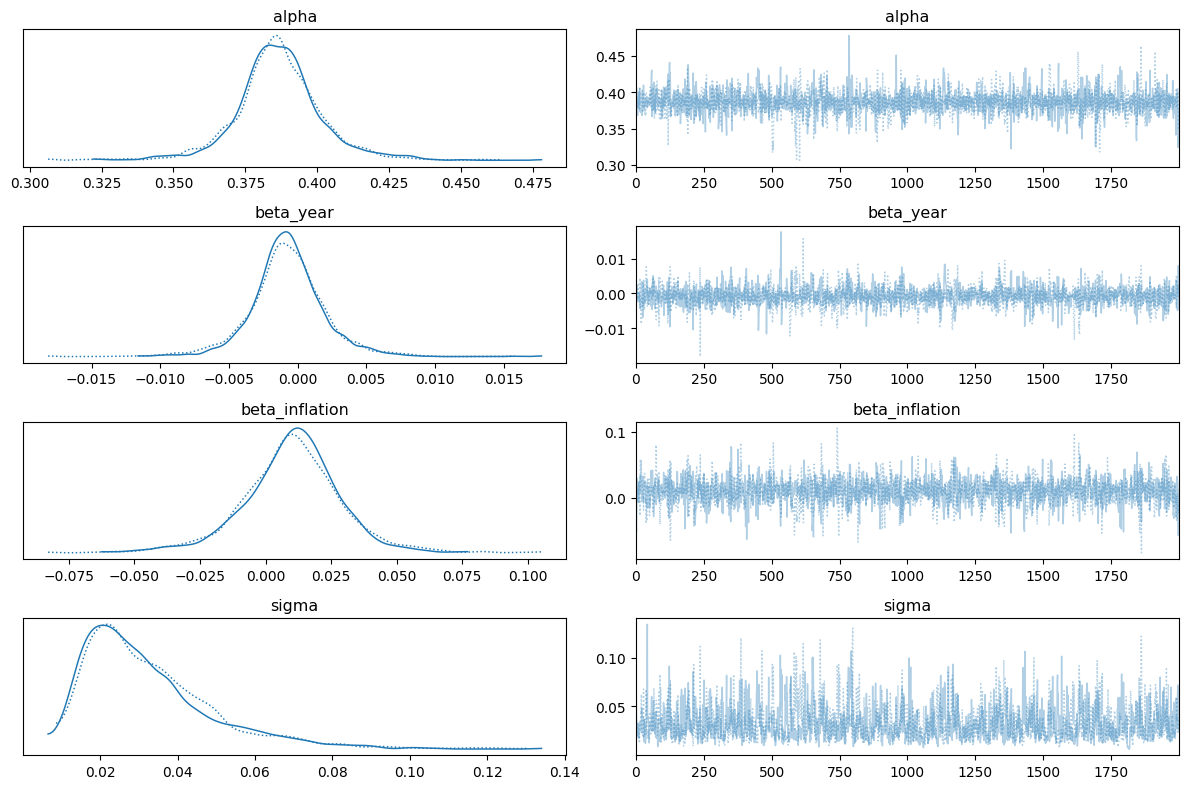

In [17]:
# Plot posterior distributions for each parameter
import matplotlib.pyplot as plt
import arviz as az

az.plot_trace(trace, var_names=["alpha", "beta_year", "beta_inflation", "sigma"])
plt.tight_layout()
plt.show()

In [18]:
az.summary(trace, var_names=["alpha", "beta_year", "beta_inflation", "sigma"], round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.3866,0.0151,0.3598,0.4183,0.0003,0.0005,2277.3737,1635.5403,1.0008
beta_year,-0.0007,0.0027,-0.0056,0.0049,0.0001,0.0001,1955.2696,1677.0852,1.0021
beta_inflation,0.0101,0.0186,-0.0270,0.0452,0.0005,0.0005,1649.6300,1634.8828,1.0008
sigma,0.0326,0.0169,0.0092,0.0647,0.0006,0.0005,761.3234,1347.1454,1.0019


1. Intercept (alpha)
The model estimates stunting is ~38.7% when both inflation and time are “average” (which is true based on your data).

This is solid — the model understands the central level of your data.

2. Effect of Time (beta_year)
Mean = -0.0007 = a tiny decline in stunting per unit of year_scaled

But: CI includes zero → the effect is statistically uncertain
- If you had more time points (e.g., annual data), the effect of year might be clearer.

3. Effect of Inflation (beta_inflation)
Mean = 0.0107 means: if inflation increases by 1 standard deviation, stunting increases by ~1 percentage point.
However: the credible interval includes 0, so we can’t say this effect is definitive with current data.
With more observations, we might detect a stronger or clearer effect.

4. Uncertainty (sigma)
Noise around predictions = ~3.3% — quite acceptable.
Means your model is not wildly off and handles your small data well


In [19]:
# Input values for prediction
future_year = 2028
future_inflation = 0.173  # 17.3%

# Use same scaling as before
year_mean = df["year"].mean()
year_scaled = future_year - year_mean

inflation_mean = df["inflation"].mean()
inflation_std = df["inflation"].std()
inflation_scaled = (future_inflation - inflation_mean) / inflation_std

# Create a dictionary to hold the new (scaled) input with the same names as the pm.Data variables
new_data = {
    "year_scaled": [year_scaled],
    "inflation_scaled": [inflation_scaled]
}

# Convert to shared variable for PyMC
with stunting_model:
    pm.set_data(new_data)
    future_pred = pm.sample_posterior_predictive(trace, var_names=["Y_obs"], random_seed=42)

display(az.summary(future_pred, var_names=["Y_obs"], round_to=4))

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1359: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Y_obs[0],0.3811,0.0522,0.2798,0.4846,0.0010,0.0014,2801.6208,2190.5130,1.0012
Y_obs[1],0.3798,0.0549,0.2818,0.4925,0.0010,0.0017,3135.6339,2061.8393,1.0019
Y_obs[2],0.3807,0.0546,0.2792,0.4896,0.0011,0.0014,2704.3981,2437.8781,1.0011
Y_obs[3],0.3808,0.0536,0.2812,0.4828,0.0010,0.0015,2924.8870,2375.6183,1.0033
Y_obs[4],0.3794,0.0548,0.2789,0.4846,0.0010,0.0017,2922.9249,2396.3128,1.0021


In [21]:
# Simulate stunting for 2028
# [25%, 30%, 35%, 40%, 45%, 50%]

import numpy as np
import matplotlib.pyplot as plt

# Define future inflation scenarios (in decimal)
inflation_rates = np.array([0.25, 0.30, 0.35, 0.40, 0.45, 0.50])
predicted_stunting = []
predicted_std = []

# Recalculate scaled year for 2028
future_year = 2028
year_scaled = future_year - df["year"].mean()

# Loop through inflation values
with stunting_model:
    for infl in inflation_rates:
        infl_scaled = (infl - inflation_mean) / inflation_std
        pm.set_data({
            "year_scaled": [year_scaled],
            "inflation_scaled": [infl_scaled]
        })
        pred = pm.sample_posterior_predictive(trace, var_names=["Y_obs"], progressbar=False).posterior_predictive
        predicted_stunting.append(pred["Y_obs"].mean().values)
        predicted_std.append(pred["Y_obs"].std().values)



/tmp/ipython-input-22-640200707.py:18: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


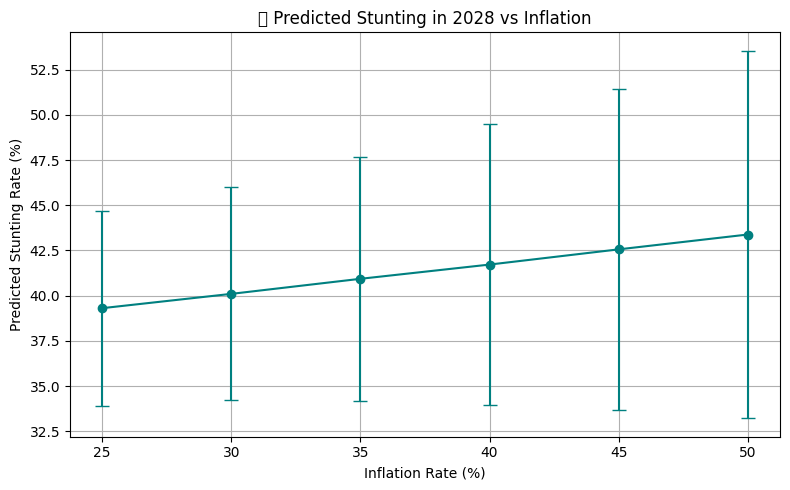

In [22]:
# Convert to NumPy for plotting
predicted_stunting = np.array(predicted_stunting)
predicted_std = np.array(predicted_std)

# Plot with error bars
plt.figure(figsize=(8, 5))
plt.errorbar(
    inflation_rates * 100,         # Convert to percent
    predicted_stunting * 100,      # Convert to percent
    yerr=predicted_std * 100,      # Also percent
    fmt='o-', capsize=5, color='teal'
)

plt.title("📉 Predicted Stunting in 2028 vs Inflation")
plt.xlabel("Inflation Rate (%)")
plt.ylabel("Predicted Stunting Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()